In [1]:

packages <- c(
    "ggplot2", 
    "dplyr", 
    "patchwork",
    "ggExtra"
)
for (pkg in packages) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                pkg,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}

In [2]:
lm_results_file_path <- file.path(
    "../results/all_features_beta_df.parquet"
)
plot_save_dir <- file.path(
    "../figures"
)
if (!dir.exists(plot_save_dir)) {
    dir.create(plot_save_dir, recursive = TRUE)
}
plot_file_path <- file.path(
    plot_save_dir,
    "lm_coefficients_colored_by_feature_type.png"
)

plot_file_path2 <- file.path(
    plot_save_dir,
    "lm_coefficients_colored_by_channel.png"
)
lm_coeff_df <- arrow::read_parquet(lm_results_file_path)
# shuffle the row order for plotting purposes
lm_coeff_df <- lm_coeff_df %>%
    dplyr::mutate(
        row_id = 1:nrow(lm_coeff_df)
    ) %>%
    dplyr::arrange(dplyr::desc(row_id)) %>%
    dplyr::select(-row_id)
head(lm_coeff_df)

beta,p_value,variate,r2,feature,Compartment,Feature_type,Channel,Channel2,featurizer_id,feature_number,Measurement,p_value_corrected
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
0.0005926981,6.415833e-06,Dose,0.5336949,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,1.185645e-05
-0.0029050912,2.053587e-23,Cell count,0.5336949,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,1.325951e-22
0.0111315473,4.081670e-11,Time,0.5336949,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,1.092255e-10
0.3335610118,3.090322e-10,const,0.5336949,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,7.789797e-10
-0.0008487948,5.050720e-12,Dose,0.3150029,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO,1.436021e-11
-0.0004727979,5.992264e-02,Cell count,0.3150029,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO,7.826965e-02


In [3]:
font_size <- 24
plot_themes <- (
    theme_bw()
    + theme(
        legend.text = element_text(size = font_size),
        legend.title = element_text(size = font_size),
        axis.title.x = element_text(size = font_size),
        axis.text.x = element_text(size = font_size),
        axis.title.y = element_text(size = font_size),
        axis.text.y = element_text(size = font_size),
        strip.text = element_text(size = font_size),
    )
)

In [4]:
lm_coeff_df$log10p_value <- -log10(lm_coeff_df$p_value)
# remove the const from the variate column
lm_coeff_df <- lm_coeff_df %>%
    filter(
        !grepl("const", variate)
    )
# if the log10p is inf then set to the max value
lm_coeff_df$log10p_value[is.infinite(lm_coeff_df$log10p_value)] <- max(
    lm_coeff_df$log10p_value[!is.infinite(lm_coeff_df$log10p_value)]
)

lm_coeff_df$Feature_type <- gsub(
    "RadialDistribution",
    "Radial\nDistibution",
    lm_coeff_df$Feature_type
)
head(lm_coeff_df)

beta,p_value,variate,r2,feature,Compartment,Feature_type,Channel,Channel2,featurizer_id,feature_number,Measurement,p_value_corrected,log10p_value
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
0.0005926981,6.415833e-06,Dose,0.5336949,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,1.185645e-05,5.192747
-0.0029050912,2.053587e-23,Cell count,0.5336949,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,1.325951e-22,22.687487
0.0111315473,4.081670e-11,Time,0.5336949,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,1.092255e-10,10.389162
-0.0008487948,5.050720e-12,Dose,0.3150029,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO,1.436021e-11,11.296647
-0.0004727979,5.992264e-02,Cell count,0.3150029,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO,7.826965e-02,1.222409
0.0131116205,9.127539e-17,Time,0.3150029,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO,3.547083e-16,16.039646


Warning message:
“Ignoring unknown parameters: linewidth”
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Warning message:
“Removed 15 rows containing missing values (geom_hline).”
Warning message:
“Duplicated override.aes is ignored.”
Warning message:
“Removed 15 rows containing missing values (geom_hline).”
Warning message:
“Duplicated override.aes is ignored.”


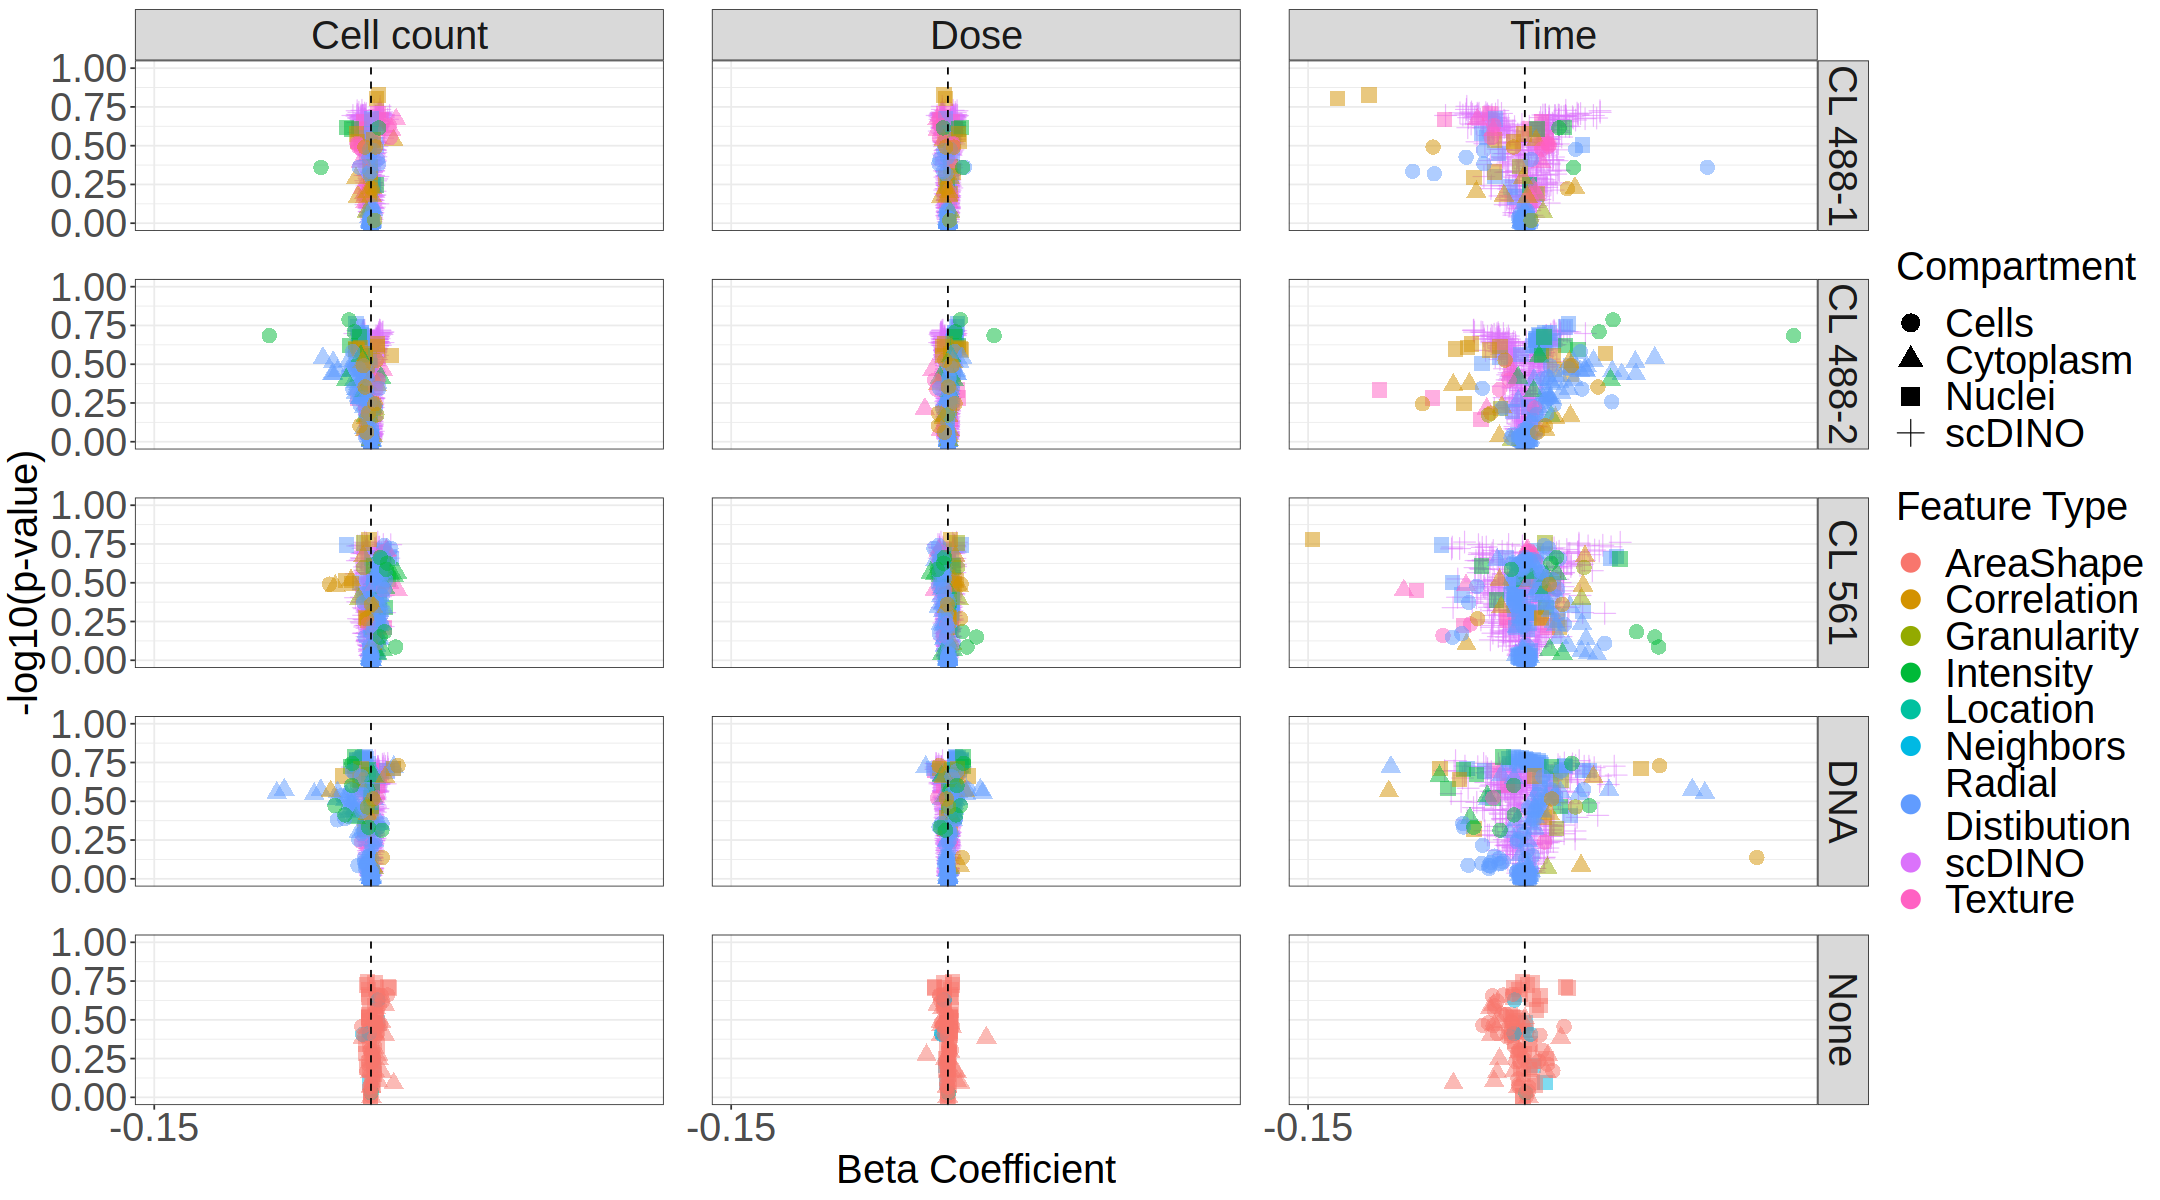

In [5]:
width <- 18
height <- 10
options(repr.plot.width = width, repr.plot.height = height)
lm_coeff_plot <- (
    ggplot(lm_coeff_df, aes(
        x = beta, 
        y = r2, 
        fill = Feature_type, 
        )
    )
    + geom_point(
        aes(
            color = Feature_type,
            shape = Compartment
        ),
        alpha = 0.5,
        stroke = 0.5,
        size = 4
    )
    + labs(
        x = "Beta Coefficient",
        y = "-log10(p-value)"
    )
    # + ylim(0, max(lm_coeff_df$log10p_value)+1)
    + geom_hline(
        yintercept = -log10(0.05),
        linetype = "dashed",
        color = "red",
        linewidth = 1
    )
    # change the the x increments 
    + ylim(0,1)
    + scale_x_continuous(
        breaks = seq(
            from = round(min(lm_coeff_df$beta),2),
            to = round(max(lm_coeff_df$beta),2),
            by = 0.1,
        )
    )
    + plot_themes
    + guides(
        fill = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Feature Type"
        ),
        color = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Feature Type"
        ),
    
        shape = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Compartment"
        )
    )

    + facet_grid(
        Channel ~ variate,

    )
    + geom_vline(
        xintercept = 0,
        linetype = "dashed",
    )
    + theme(
        panel.spacing = unit(2, "lines")  # Adjust spacing between facets
    )
        # change the the x increments 
    + scale_x_continuous(
        breaks = seq(
            from = round(min(lm_coeff_df$beta),2),
            to = round(max(lm_coeff_df$beta),2),
            by = 0.4,
        )
    )
)
ggsave(
    filename = plot_file_path,
    plot = lm_coeff_plot,
    device = "png",
    width = width,
    height = height,
    dpi = 600,
    units = "in",
)
lm_coeff_plot     


Warning message:
“Ignoring unknown parameters: linewidth”


Warning message:
“Removed 27 rows containing missing values (geom_hline).”
Warning message:
“Duplicated override.aes is ignored.”
Warning message:
“Removed 27 rows containing missing values (geom_hline).”
Warning message:
“Duplicated override.aes is ignored.”


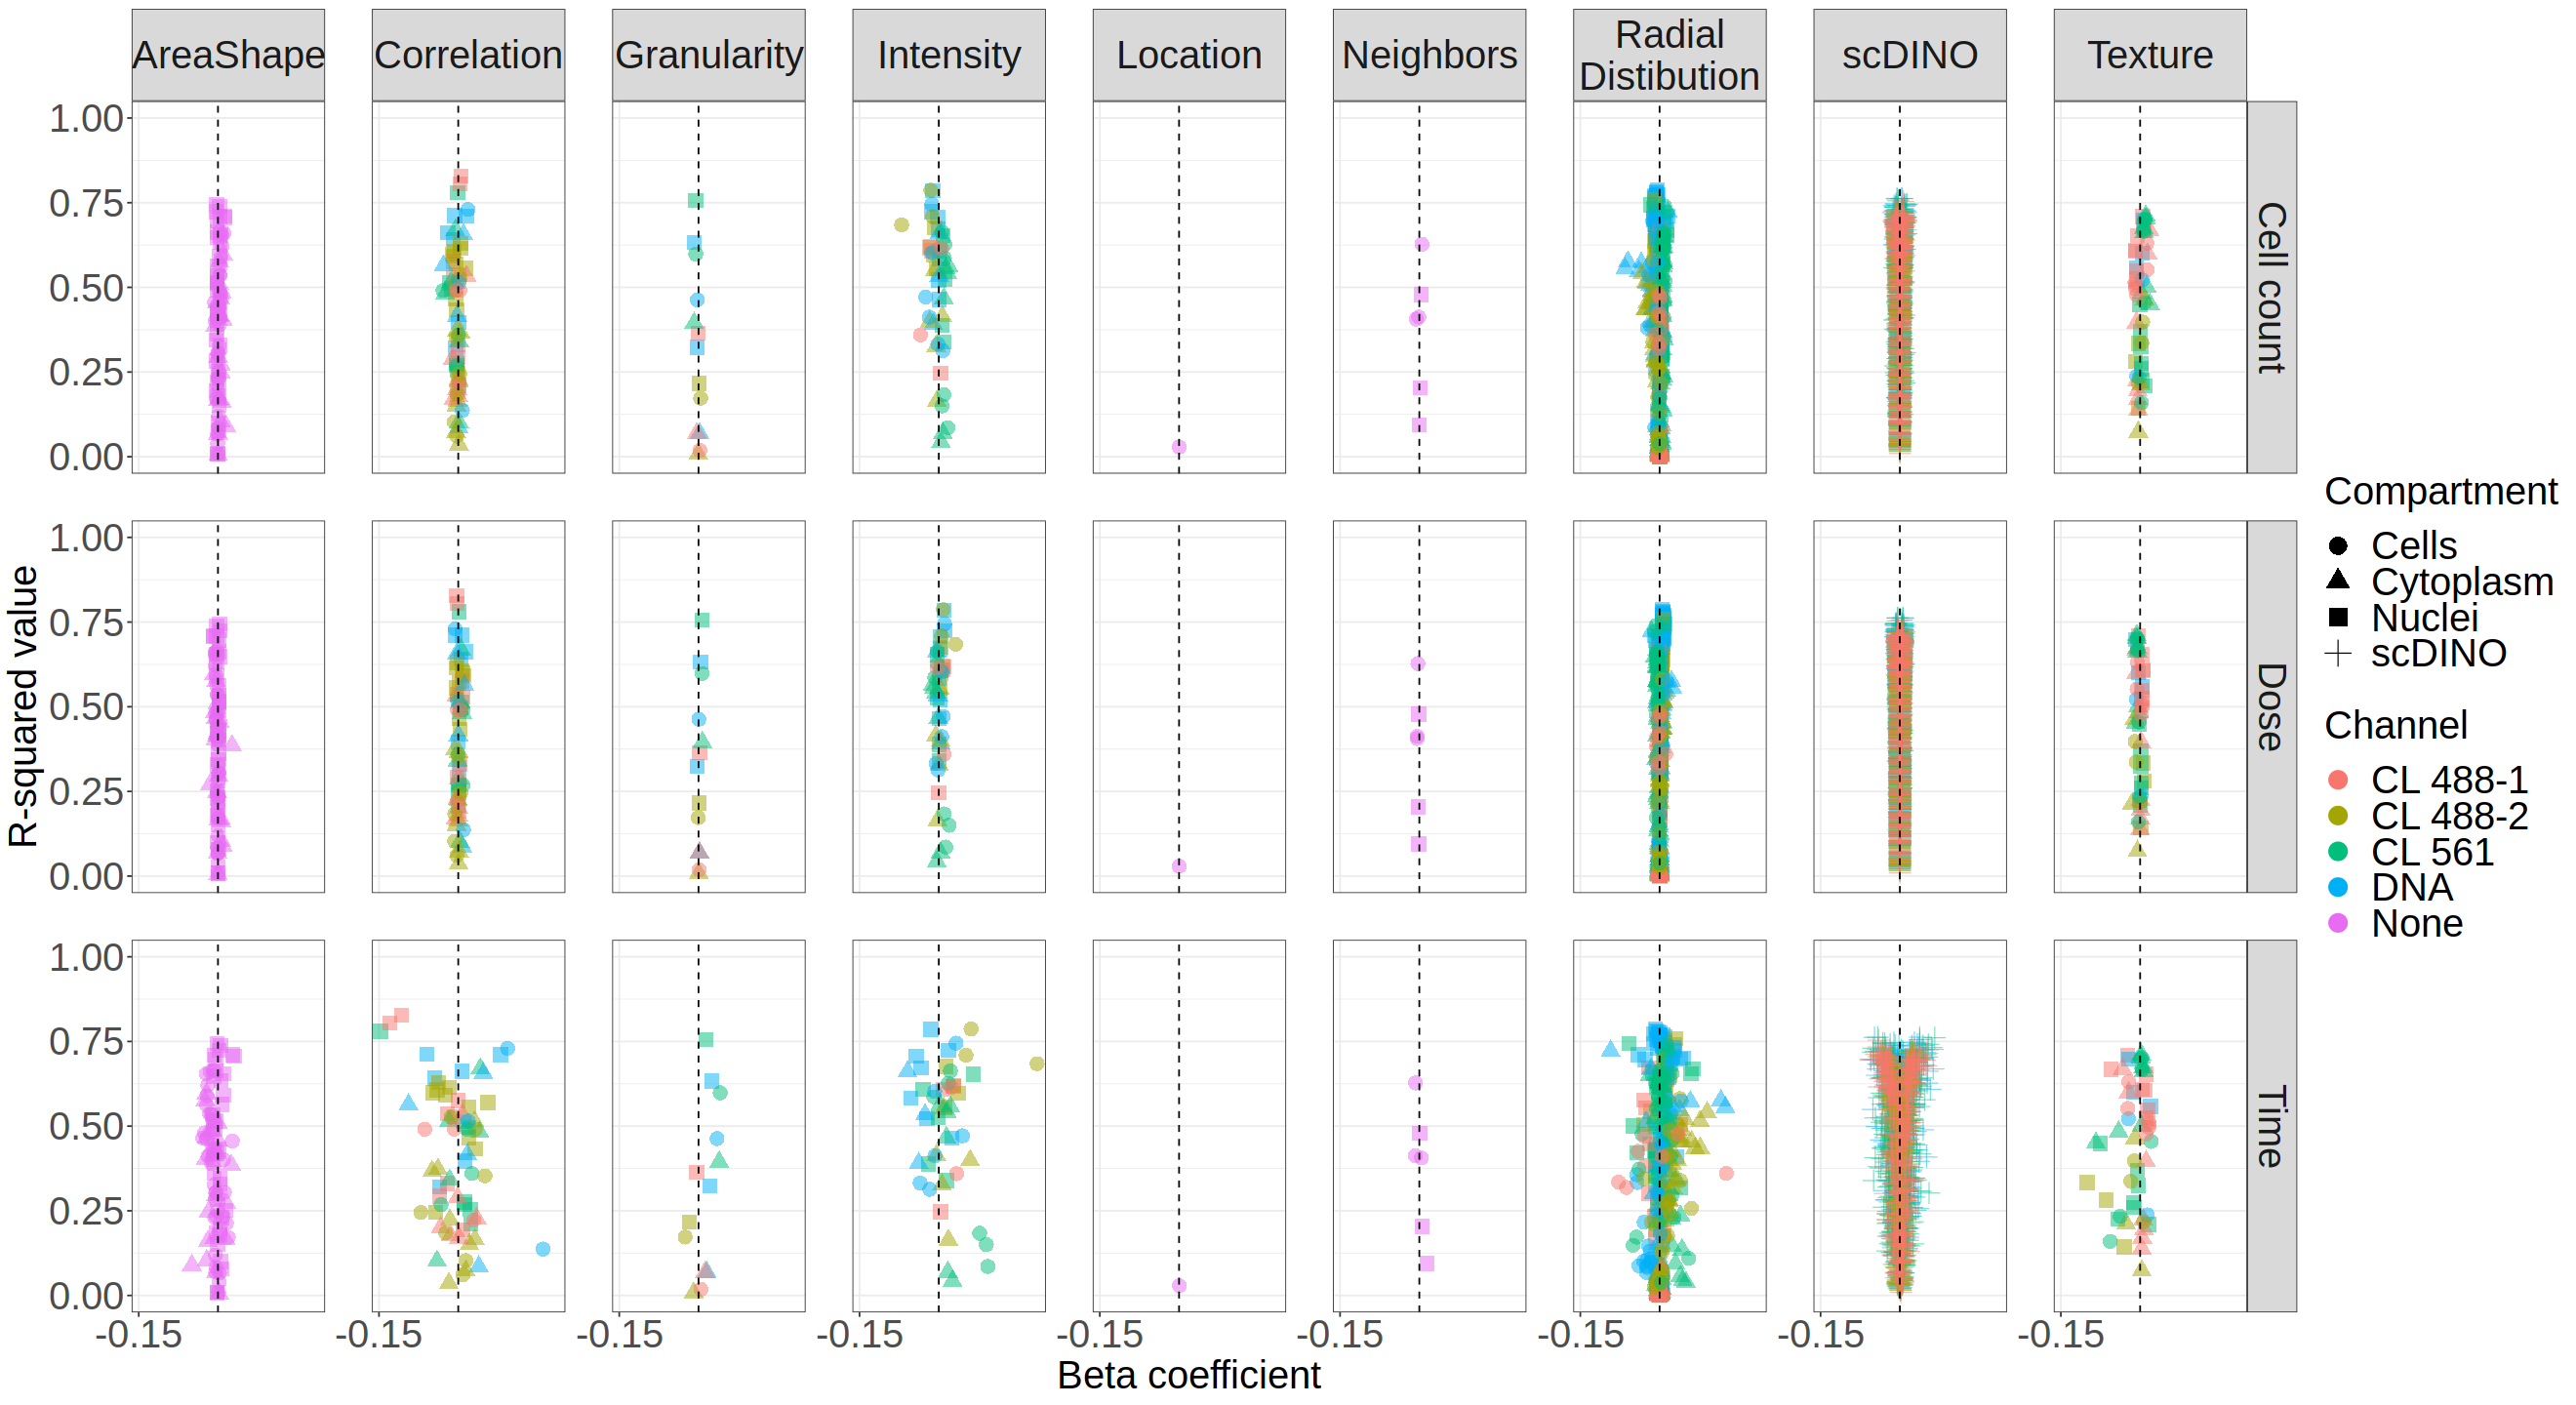

In [6]:
width <- 22
height <- 12
options(repr.plot.width = width, repr.plot.height = height)
lm_coeff_plot2 <- (
    ggplot(lm_coeff_df, aes(
        x = beta, 
        y = r2, 
        fill = Channel, 
        )
    )
    + geom_point(
        aes(
            color = Channel,
            shape = Compartment
        ),
        alpha = 0.5,
        stroke = 0.5,
        size = 4
    )
    + labs(
        x = "Beta coefficient",
        y = "R-squared value"
    )
    # + ylim(0, max(lm_coeff_df$log10p_value)+1)
    + geom_hline(
        yintercept = -log10(0.05),
        linetype = "dashed",
        color = "red",
        linewidth = 1
    )
    + ylim(0,1)

    + plot_themes
    + guides(
        fill = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Channel"
        ),
        color = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Channel"
        ),
    
        shape = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Compartment"
        )
    )
    + facet_grid(
        variate ~ Feature_type,

    )
    + geom_vline(
        xintercept = 0,
        linetype = "dashed",
    )
        + theme(
        panel.spacing = unit(2, "lines")  # Adjust spacing between facets
    )
        # change the the x increments 
    + scale_x_continuous(
        breaks = seq(
            from = round(min(lm_coeff_df$beta),2),
            to = round(max(lm_coeff_df$beta),2),
            by = 0.4,
        )
    )
)
ggsave(
    filename = plot_file_path2,
    plot = lm_coeff_plot2,
    device = "png",
    width = width,
    height = height,
    dpi = 600,
    units = "in",
)
lm_coeff_plot2   
